In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-10 17:08:27.769608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 17:08:27.882739: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-10 17:08:28.268479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/billiam/miniconda3/envs/tf/lib/
2023-02-10 17:08:28.268533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [2]:
# download the data from kaggle: 
# https://www.kaggle.com/ihelon/lego-minifigures-tensorflow-tutorial
# move the folder into your project folder and create a backup of
# the star-wars images at 'lego/star-wars-images/'
BASE_DIR = 'images/'
names = ["3003", "3004", "3021", "6091", "852929"]

tf.random.set_seed(1)

In [3]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
# Moce the image files
orig_folders = [name + "/" for name in names]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


In [5]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#    rotation_range=20,
#    horizontal_flip=True,
#    width_shift_range=0.2, height_shift_range=0.2,
#    shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 8463 images belonging to 5 classes.
Found 3528 images belonging to 5 classes.
Found 2115 images belonging to 5 classes.


In [6]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 0. 1. 3.]
(4, 256, 256, 3)
[0. 0. 0. 0.]


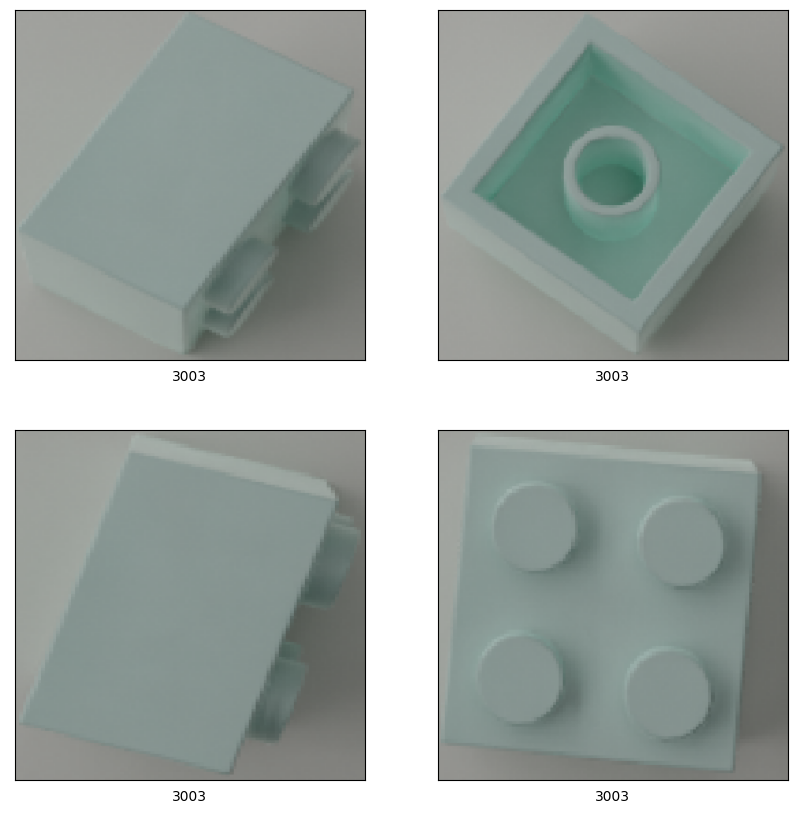

In [7]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

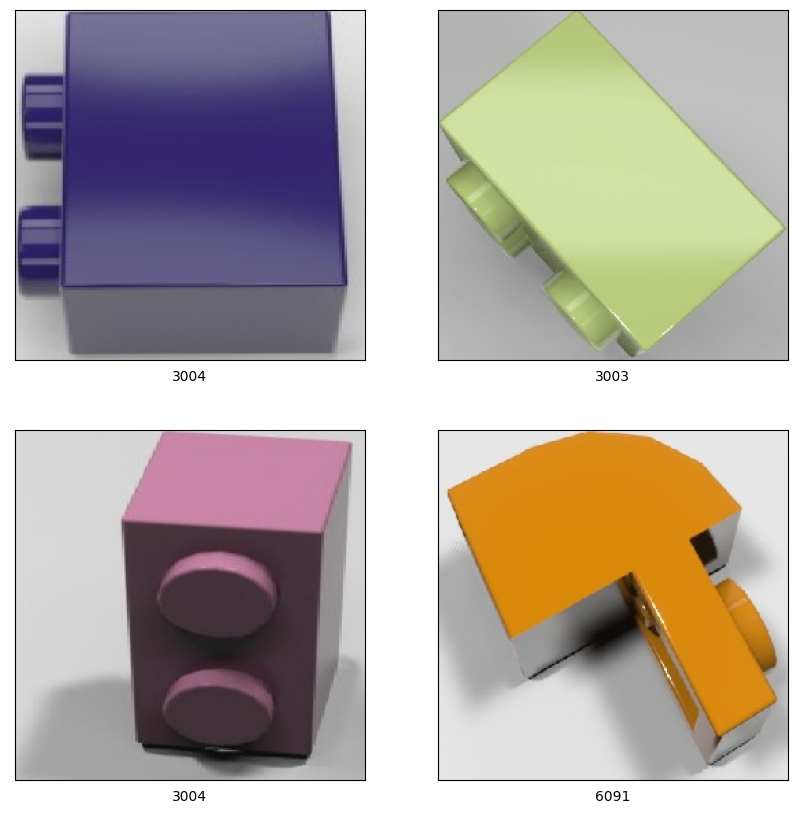

In [8]:
show(train_batch)

In [9]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

2023-02-10 17:08:51.524164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 17:08:51.527696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 17:08:51.528149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 17:08:51.528887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [11]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=2)

Epoch 1/30


2023-02-10 17:08:59.595752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-10 17:09:00.113334: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-10 17:09:00.114059: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-10 17:09:00.114073: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-10 17:09:00.114657: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-10 17:09:00.114694: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-10 17:09:00.591892: I tensorflow/stream_executor/cuda/c

2116/2116 - 24s - loss: 1.3684 - accuracy: 0.4216 - val_loss: 1.0485 - val_accuracy: 0.5513 - 24s/epoch - 11ms/step
Epoch 2/30
2116/2116 - 21s - loss: 0.8816 - accuracy: 0.6427 - val_loss: 0.7371 - val_accuracy: 0.7120 - 21s/epoch - 10ms/step
Epoch 3/30
2116/2116 - 21s - loss: 0.5212 - accuracy: 0.8007 - val_loss: 0.6321 - val_accuracy: 0.7823 - 21s/epoch - 10ms/step
Epoch 4/30
2116/2116 - 21s - loss: 0.2907 - accuracy: 0.8957 - val_loss: 0.7019 - val_accuracy: 0.8087 - 21s/epoch - 10ms/step
Epoch 5/30
2116/2116 - 21s - loss: 0.1857 - accuracy: 0.9390 - val_loss: 0.8768 - val_accuracy: 0.8041 - 21s/epoch - 10ms/step
Epoch 6/30
2116/2116 - 21s - loss: 0.1186 - accuracy: 0.9614 - val_loss: 0.9886 - val_accuracy: 0.8214 - 21s/epoch - 10ms/step
Epoch 7/30
2116/2116 - 22s - loss: 0.0679 - accuracy: 0.9805 - val_loss: 1.1795 - val_accuracy: 0.8172 - 22s/epoch - 10ms/step
Epoch 8/30
2116/2116 - 22s - loss: 0.0938 - accuracy: 0.9764 - val_loss: 1.3163 - val_accuracy: 0.7931 - 22s/epoch - 10ms/

In [12]:
model.save("lego_model.h5")

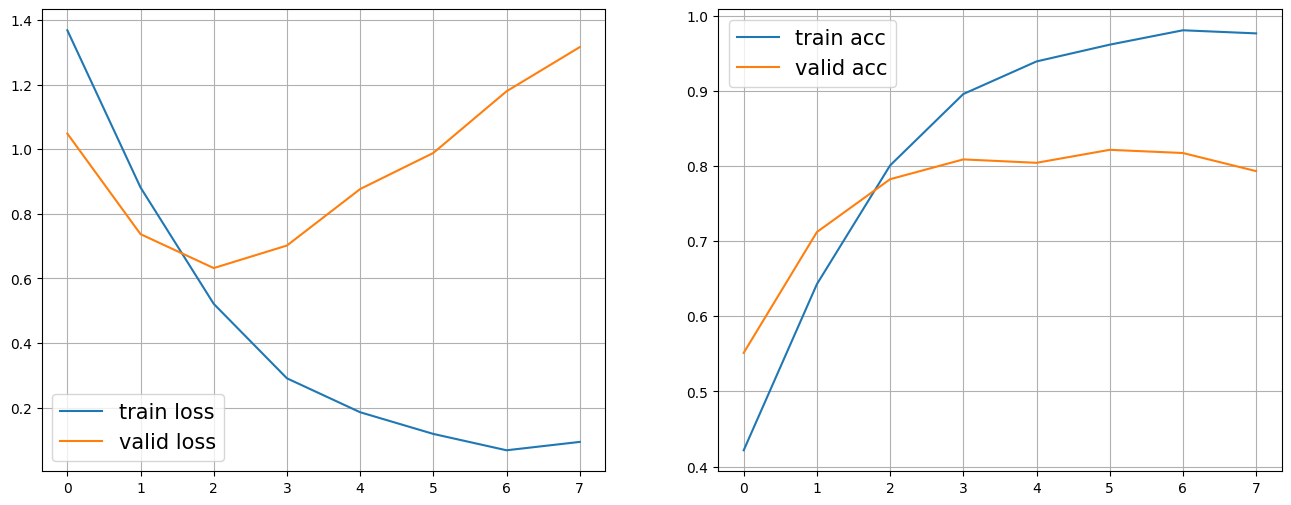

In [13]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [14]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

529/529 - 2s - loss: 1.3593 - accuracy: 0.7830 - 2s/epoch - 4ms/step


[1.3592846393585205, 0.7829787135124207]

In [15]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

529/529 [==============================] - 2s 4ms/step
[0. 0. 0. 0.]
[1 0 1 0]


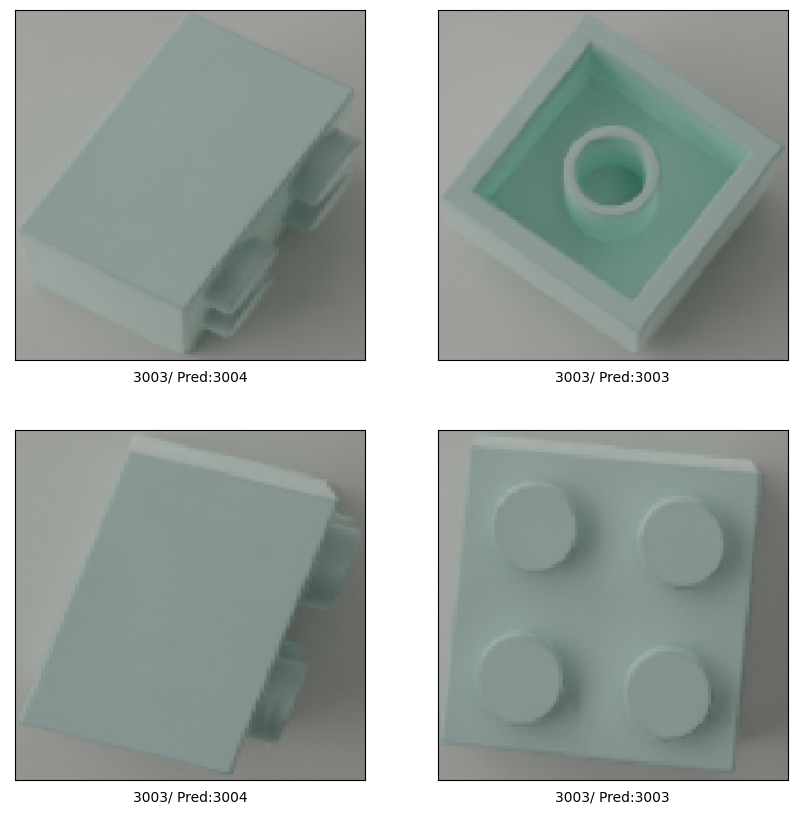

In [16]:
show(test_batches[0], labels[0:4])

# Transfer Learning

In [17]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# try out different ones, e.g. MobileNetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()


<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (Ma

In [18]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [20]:
# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [21]:
# add a last classification layer for our use case with 5 classes
model.add(layers.Dense(5))

In [22]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [23]:
# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [24]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 8463 images belonging to 5 classes.
Found 3528 images belonging to 5 classes.
Found 2115 images belonging to 5 classes.


In [25]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
2116/2116 - 57s - loss: 0.5240 - accuracy: 0.8352 - val_loss: 0.4066 - val_accuracy: 0.8926 - 57s/epoch - 27ms/step
Epoch 2/30
2116/2116 - 55s - loss: 0.3246 - accuracy: 0.9005 - val_loss: 0.3944 - val_accuracy: 0.8957 - 55s/epoch - 26ms/step
Epoch 3/30
2116/2116 - 55s - loss: 0.2271 - accuracy: 0.9285 - val_loss: 0.2975 - val_accuracy: 0.9192 - 55s/epoch - 26ms/step
Epoch 4/30
2116/2116 - 55s - loss: 0.2341 - accuracy: 0.9337 - val_loss: 0.2744 - val_accuracy: 0.9368 - 55s/epoch - 26ms/step
Epoch 5/30
2116/2116 - 55s - loss: 0.2010 - accuracy: 0.9422 - val_loss: 0.4215 - val_accuracy: 0.9130 - 55s/epoch - 26ms/step
Epoch 6/30
2116/2116 - 55s - loss: 0.1678 - accuracy: 0.9497 - val_loss: 0.3466 - val_accuracy: 0.9087 - 55s/epoch - 26ms/step
Epoch 7/30
2116/2116 - 55s - loss: 0.1548 - accuracy: 0.9552 - val_loss: 0.2769 - val_accuracy: 0.9422 - 55s/epoch - 26ms/step
Epoch 8/30
2116/2116 - 55s - loss: 0.1282 - accuracy: 0.9631 - val_loss: 0.2505 - val_accuracy: 0.9376 - 55s/ep

In [26]:
model.evaluate(test_batches, verbose=2)

529/529 - 10s - loss: 0.2592 - accuracy: 0.9499 - 10s/epoch - 19ms/step


[0.25921428203582764, 0.9498817920684814]

529/529 [==============================] - 10s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0.]
[1 0 1 0]


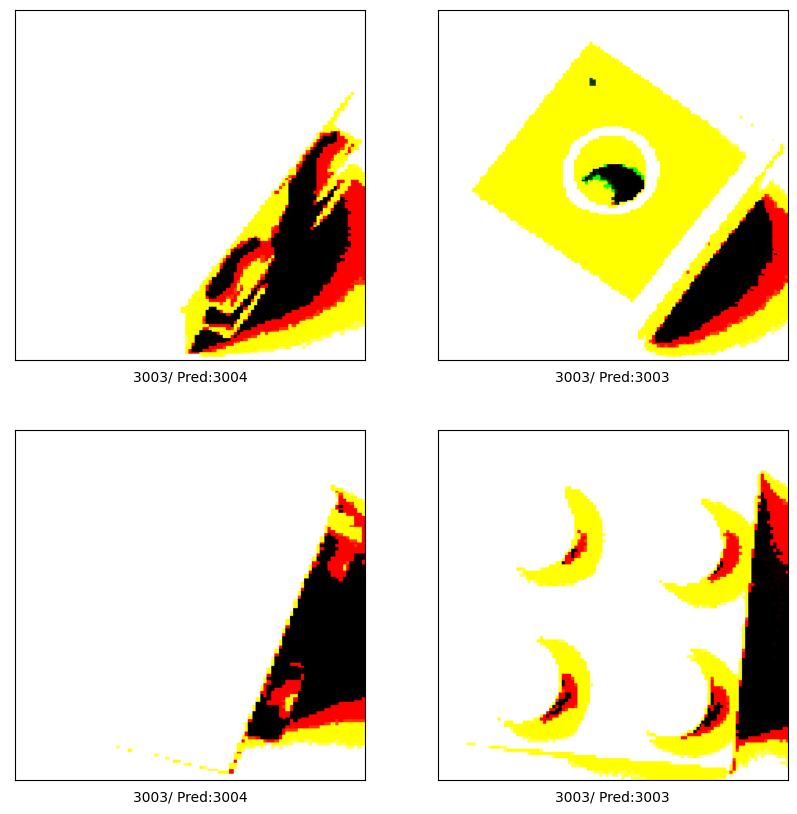

In [27]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

show(test_batches[0], labels[0:4])